# COM502: Machine Learning
## Term Paper

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from arch import arch_model
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
first = pd.read_csv("../data/return_first.csv", index_col=0)
full = pd.read_csv("../data/return_full.csv", index_col=0)
last = pd.read_csv("../data/return_last.csv", index_col=0)

In [4]:
# Estimate how well the 10 large-cap stocks explain the composite index through regression analysis
X = full[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']]
Y = full['Y']

# Add constant term to explanatory variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     652.8
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:48:52   Log-Likelihood:                -721.83
No. Observations:                1222   AIC:                             1466.
Df Residuals:                    1211   BIC:                             1522.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0192      0.013     -1.523      0.1

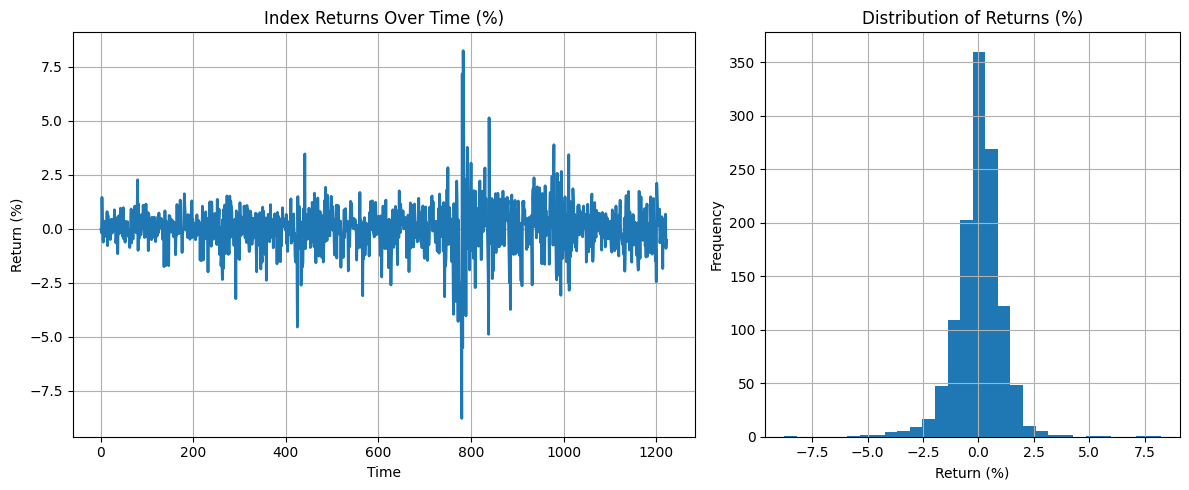

In [5]:
# Plotting index returns and their distribution (percentage)
subplots_ratio = dict(width_ratios=[3, 2], height_ratios=[1])
fig, ax = plt.subplots(1, 2, gridspec_kw=subplots_ratio, figsize=(12, 5))

# Time series plot of index returns (in %)
full['Y'].plot(title='Index Returns Over Time (%)', ax=ax[0], grid=True, linewidth=2)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Return (%)')

# Histogram of returns distribution (in %)
full['Y'].plot.hist(title='Distribution of Returns (%)', ax=ax[1], grid=True, bins=30)
ax[1].set_xlabel('Return (%)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()

## 1) Identifying Non-Gaussian Periods

### 1-1) Eyeball test

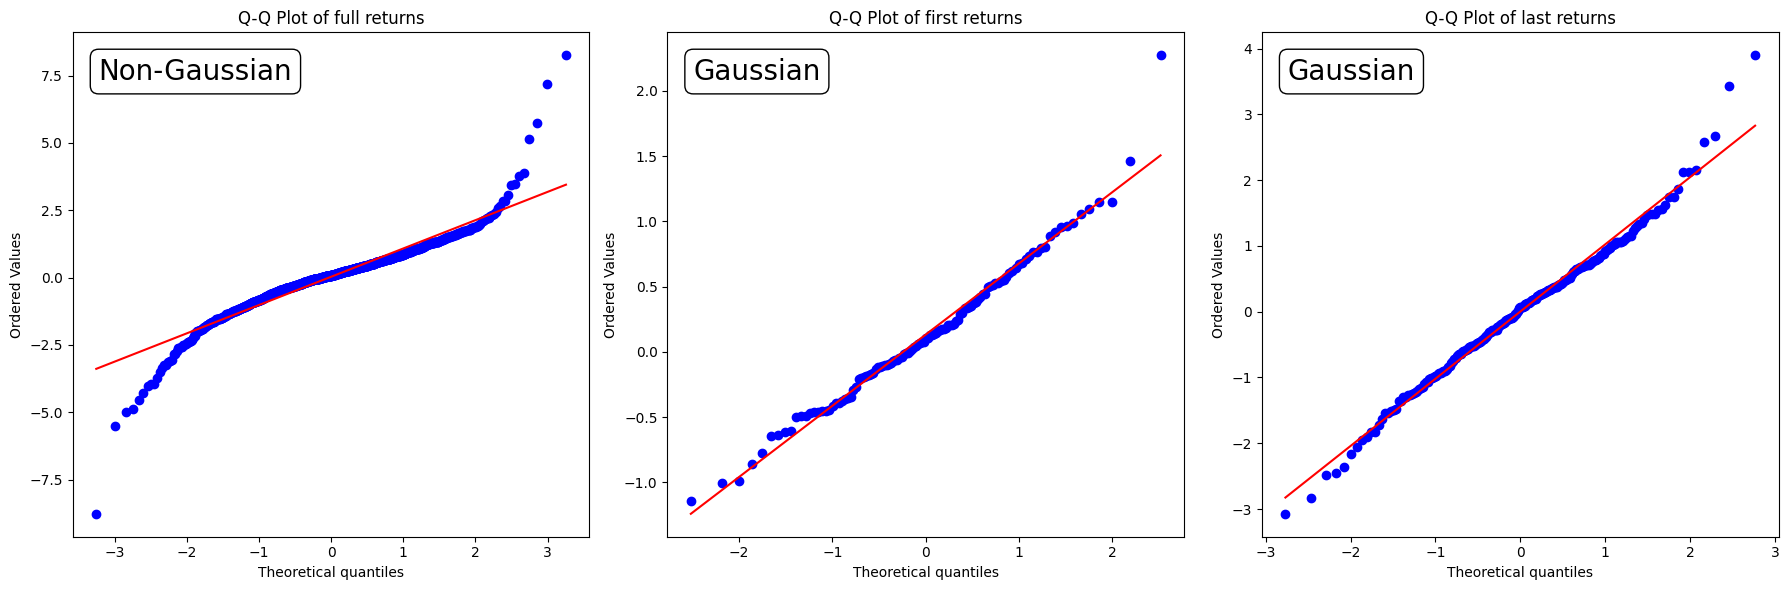

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# full returns Q-Q plot
stats.probplot(full['Y'], dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot of full returns")
axs[0].text(0.05, 0.95, 'Non-Gaussian', transform=axs[0].transAxes, fontsize=20, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# first returns Q-Q plot
stats.probplot(first['Y'], dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot of first returns")
axs[1].text(0.05, 0.95, 'Gaussian', transform=axs[1].transAxes, fontsize=20, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# last returns Q-Q plot
stats.probplot(last['Y'], dist="norm", plot=axs[2])
axs[2].set_title("Q-Q Plot of last returns")
axs[2].text(0.05, 0.95, 'Gaussian', transform=axs[2].transAxes, fontsize=20, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.savefig("../figures/Q-Q_plots.png")
plt.show()

In [7]:
# Perform Kolmogorov-Smirnov test on the coposite index
full_stat, full_p_value = sm.stats.diagnostic.kstest_normal(full['Y'])
first_stat, first_p_value = sm.stats.diagnostic.kstest_normal(first['Y'])
last_stat, last_p_value = sm.stats.diagnostic.kstest_normal(last['Y'])

# Print K-S Statistic & p-value
print(f"Full K-S Statistic: {full_stat}, p-value: {full_p_value}")  # non-Gaussian
print(f"First K-S Statistic: {first_stat}, p-value: {first_p_value}")  # Gaussian
print(f"Last K-S Statistic: {last_stat}, p-value: {last_p_value}")  # Gaussian

Full K-S Statistic: 0.08530650474605467, p-value: 0.0009999999999998899
First K-S Statistic: 0.06284805695088147, p-value: 0.3590288278921271
Last K-S Statistic: 0.03775633340154083, p-value: 0.5996768790537994


### 1-2) Splitting the data into sub-intervals

In [8]:
data_length = full.shape[0]

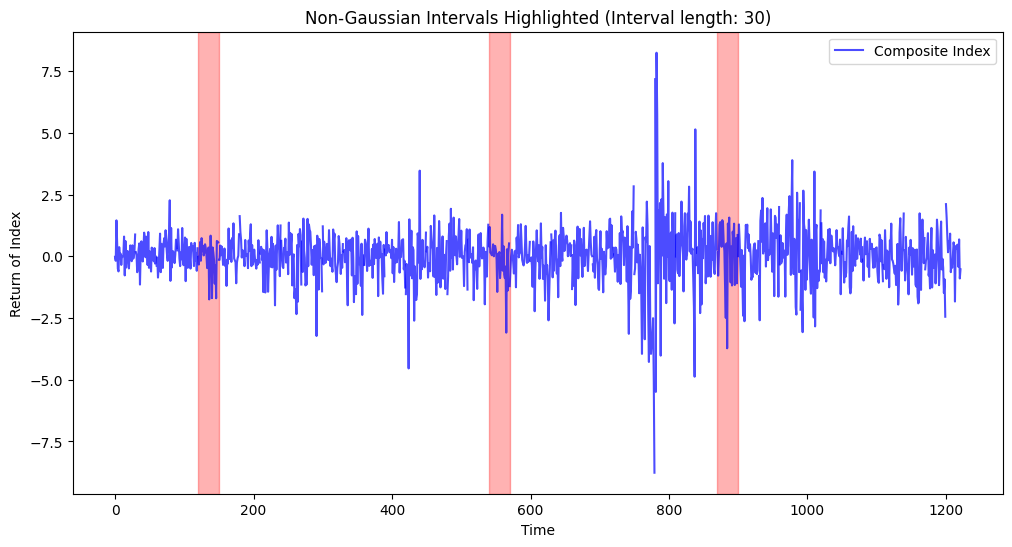

In [9]:
# Setting sub-intervals by month

# the interval length (monthly)
interval_length = 30

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Perform normality test and visualize for each interval
for start_index in range(0, data_length, interval_length):
    end_index = min(start_index + interval_length, data_length)
    interval = full['Y'].values[start_index:end_index]
    
    x = np.arange(start_index, end_index)
    y = interval
    
    # Kolmogorov-Smirnov test for normality
    k2, p_value = sm.stats.diagnostic.kstest_normal(y)
    
    if p_value > 0.05:
        # Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
    else:
        # Non-Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
        ax.axvspan(start_index, end_index, color='red', alpha=0.3)  # Transparent red box indicates non-Gaussian interval

# Plot settings
ax.set_title(f'Non-Gaussian Intervals Highlighted (Interval length: {interval_length})')
ax.set_xlabel('Time')
ax.set_ylabel('Return of Index')
plt.legend(['Composite Index'])
plt.savefig("../figures/sub-interval_30.png")
plt.show()

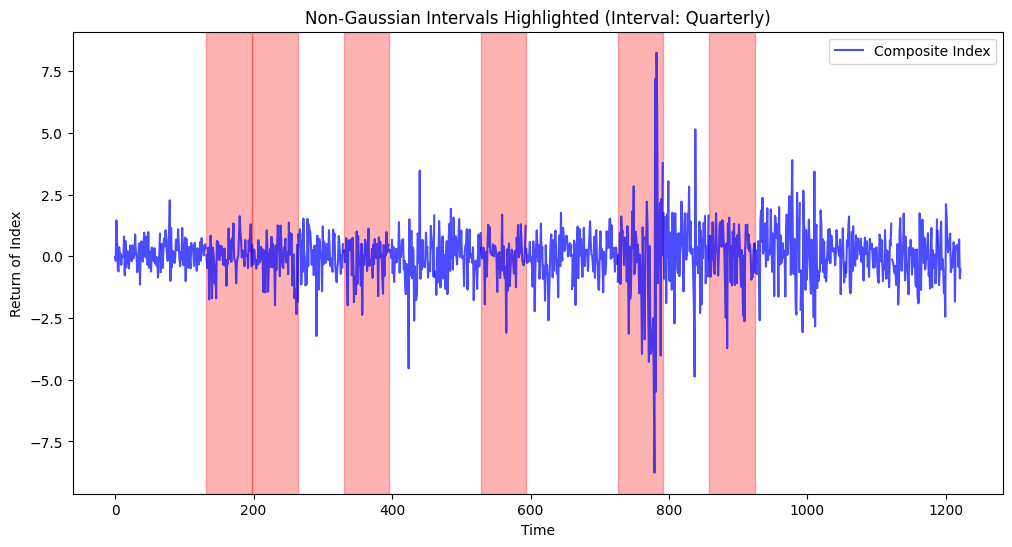

In [10]:
# Setting sub-intervals by quarter

# Set interval length (quarterly)
interval_length = 66

# Prepare visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Perform normality test and visualize for each interval
for start_index in range(0, data_length, interval_length):
    end_index = min(start_index + interval_length, data_length)
    interval = full['Y'].values[start_index:end_index]
    
    x = np.arange(start_index, end_index)
    y = interval
    
    # Kolmogorov-Smirnov test for normality
    k2, p_value = sm.stats.diagnostic.kstest_normal(y)
    
    if p_value > 0.05:
        # Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
    else:
        # Non-Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
        ax.axvspan(start_index, end_index, color='red', alpha=0.3)  # Transparent red box indicates non-Gaussian interval

# Plot settings
ax.set_title(f'Non-Gaussian Intervals Highlighted (Interval: Quarterly)')
ax.set_xlabel('Time')
ax.set_ylabel('Return of Index')
plt.legend(['Composite Index'])
plt.savefig("../figures/sub-interval_q.png")
plt.show()

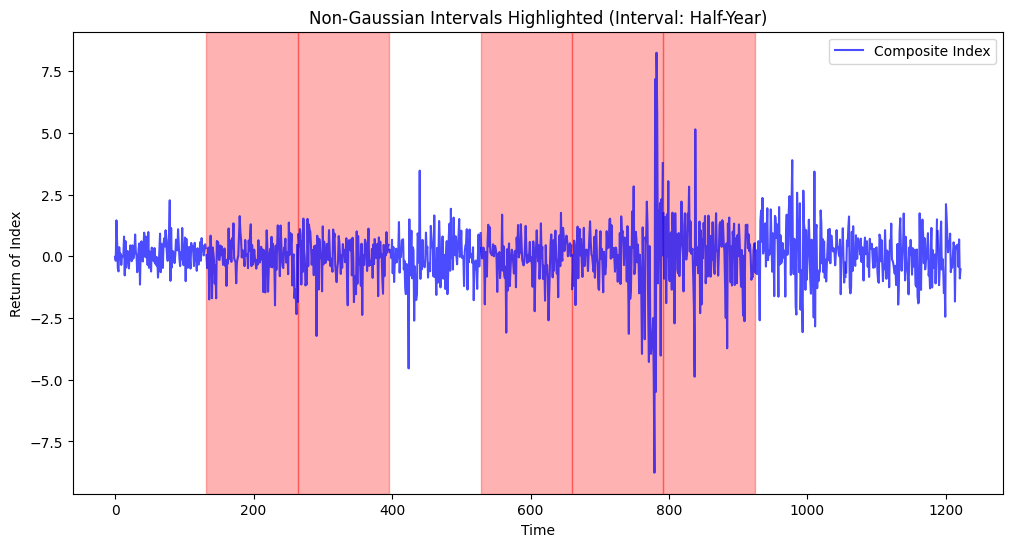

In [11]:
# Setting sub-intervals by half-year

# Set interval length (half-year)
interval_length = 132

# Prepare visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Perform normality test and visualize for each interval
for start_index in range(0, data_length, interval_length):
    end_index = min(start_index + interval_length, data_length)
    interval = full['Y'].values[start_index:end_index]
    
    x = np.arange(start_index, end_index)
    y = interval
    
    # Kolmogorov-Smirnov test for normality
    k2, p_value = sm.stats.diagnostic.kstest_normal(y)
    
    if p_value > 0.05:
        # Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
    else:
        # Non-Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
        ax.axvspan(start_index, end_index, color='red', alpha=0.3)  # Transparent red box indicates non-Gaussian interval

# Plot settings
ax.set_title(f'Non-Gaussian Intervals Highlighted (Interval: Half-Year)')
ax.set_xlabel('Time')
ax.set_ylabel('Return of Index')
plt.legend(['Composite Index'])
plt.savefig("../figures/sub-interval_h.png")
plt.show()

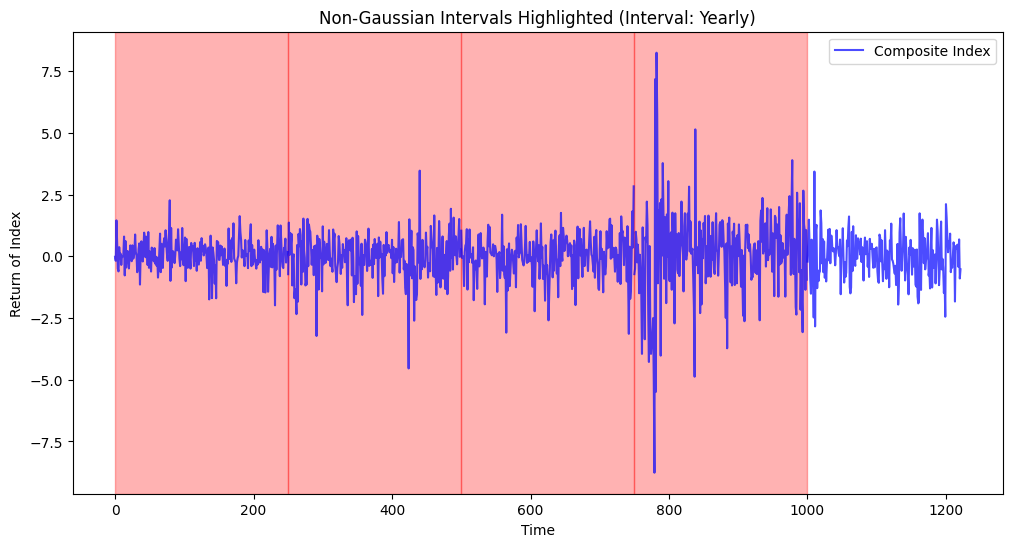

In [12]:
# Setting sub-intervals by year

# Set interval length (yearly)
interval_length = 250

# Prepare visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Perform normality test and visualize for each interval
for start_index in range(0, data_length, interval_length):
    end_index = min(start_index + interval_length, data_length)
    interval = full['Y'].values[start_index:end_index]
    
    x = np.arange(start_index, end_index)
    y = interval
    
    # Kolmogorov-Smirnov test for normality
    k2, p_value = sm.stats.diagnostic.kstest_normal(y)
    
    if p_value > 0.05:
        # Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
    else:
        # Non-Gaussian interval
        ax.plot(x, y, color='blue', alpha=0.7)
        ax.axvspan(start_index, end_index, color='red', alpha=0.3)  # Transparent red box indicates non-Gaussian interval

# Plot settings
ax.set_title(f'Non-Gaussian Intervals Highlighted (Interval: Yearly)')
ax.set_xlabel('Time')
ax.set_ylabel('Return of Index')
plt.legend(['Composite Index'])
plt.savefig("../figures/sub-interval_y.png")
plt.show()

### 1-3) Rolling statistics from 1st to 4th moments

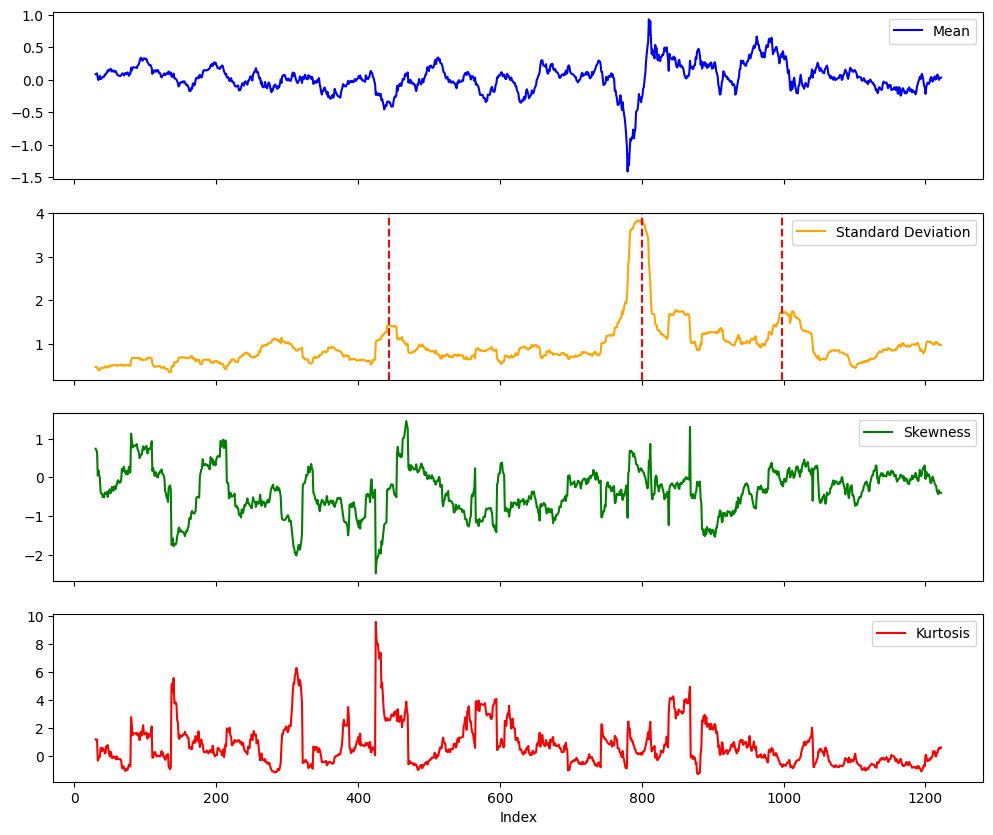

In [13]:
Y_data = full['Y'].copy()

# Calculate rolling mean, rolling standard deviation, rolling skewness, and rolling kurtosis
window = 30
rolling_mean = Y_data.rolling(window).mean()
rolling_std = Y_data.rolling(window).std()
rolling_skew = Y_data.rolling(window).skew()
rolling_kurtosis = Y_data.rolling(window).kurt()

# Find index with the highest rolling std between 400 and 500
max_std_index_400_500 = rolling_std[400:500].idxmax()
# Find index with the highest rolling std between 750 and 850
max_std_index_750_850 = rolling_std[750:850].idxmax()
# Find index with the highest rolling std between 950 and 1050
max_std_index_950_1050 = rolling_std[950:1050].idxmax()

# Prepare visualization
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Rolling mean plot
axs[0].plot(rolling_mean, label='Mean', color='blue')
axs[0].legend()

# Rolling std plot
axs[1].plot(rolling_std, label='Standard Deviation', color='orange')
# Mark highest std points with red dashed lines
axs[1].axvline(x=max_std_index_400_500, color='red', linestyle='--')
axs[1].axvline(x=max_std_index_750_850, color='red', linestyle='--')
axs[1].axvline(x=max_std_index_950_1050, color='red', linestyle='--')
axs[1].legend()

# Rolling skewness plot
axs[2].plot(rolling_skew, label='Skewness', color='green')
axs[2].legend()

# Rolling kurtosis plot
axs[3].plot(rolling_kurtosis, label='Kurtosis', color='red')
axs[3].legend()

plt.xlabel('Index')
plt.savefig('../figures/rolling_statistics.png')
plt.show()

### 1-4) GMM & GARCH

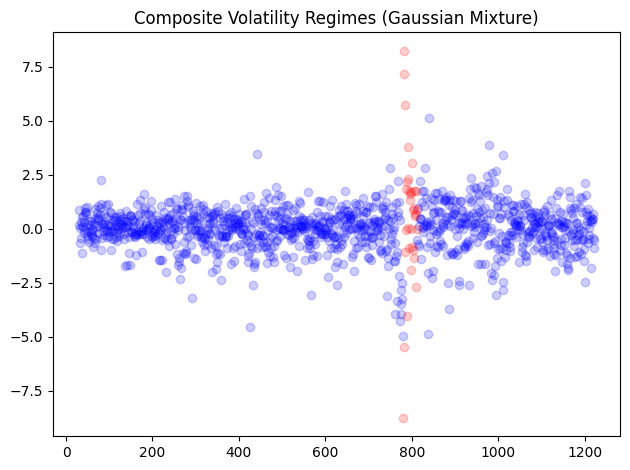

In [14]:
w = 30
vol = full['Y'].rolling(w).std()
vol = vol.dropna()

labels = GaussianMixture(2).fit_predict(vol.values.reshape(-1, 1))

composite = full['Y'].reindex(vol.index)
composite[labels == 0].plot(style='bo', alpha=0.2)
composite[labels == 1].plot(style='ro', alpha=0.2)
plt.title('Composite Volatility Regimes (Gaussian Mixture)')
plt.tight_layout()
# plt.savefig('../figures/gmm.png')

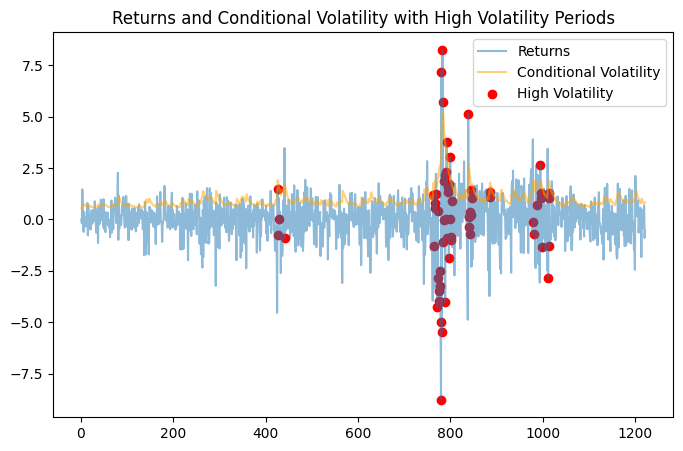

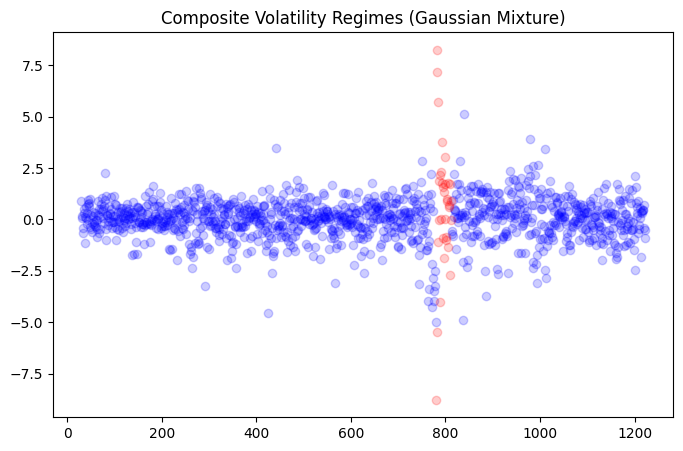

In [15]:
data = full['Y'].copy()

# GARCH(1, 1) 모델 적합
model = arch_model(data, vol='Garch', p=1, q=1)
model_fitted = model.fit(disp='off')

# 조건부 변동성 추정
conditional_volatility = model_fitted.conditional_volatility

# 변동성이 높은 구간 식별 (예: 변동성이 상위 10%인 구간)
threshold = conditional_volatility.quantile(0.95)
high_volatility_indices = conditional_volatility[conditional_volatility > threshold].index

# 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(data.index, data, label='Returns', alpha=0.5)
plt.plot(conditional_volatility.index, conditional_volatility, color='orange', label='Conditional Volatility', alpha=0.5)
plt.scatter(high_volatility_indices, data.loc[high_volatility_indices], color='red', label='High Volatility', marker='o')
plt.title('Returns and Conditional Volatility with High Volatility Periods')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
composite = full['Y'].reindex(vol.index)
composite[labels == 0].plot(style='bo', alpha=0.2)
composite[labels == 1].plot(style='ro', alpha=0.2)
plt.title('Composite Volatility Regimes (Gaussian Mixture)')
plt.show()

In [16]:
# Extract indices for both regimes
# Non-Gaussian regime (where labels == 1)
non_gaussian_indices = vol.index[labels == 1]

# Gaussian (normal) regime (all other indices)
gaussian_indices = vol.index.difference(non_gaussian_indices)

# Print the results
print(non_gaussian_indices)
print(gaussian_indices)

Index([780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
       794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807,
       808, 809, 810, 811, 812],
      dtype='int64')
Index([  30,   31,   32,   33,   34,   35,   36,   37,   38,   39,
       ...
       1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222],
      dtype='int64', length=1160)


## 2) Extracting the Latent Factor

### Correlation with individual stocks

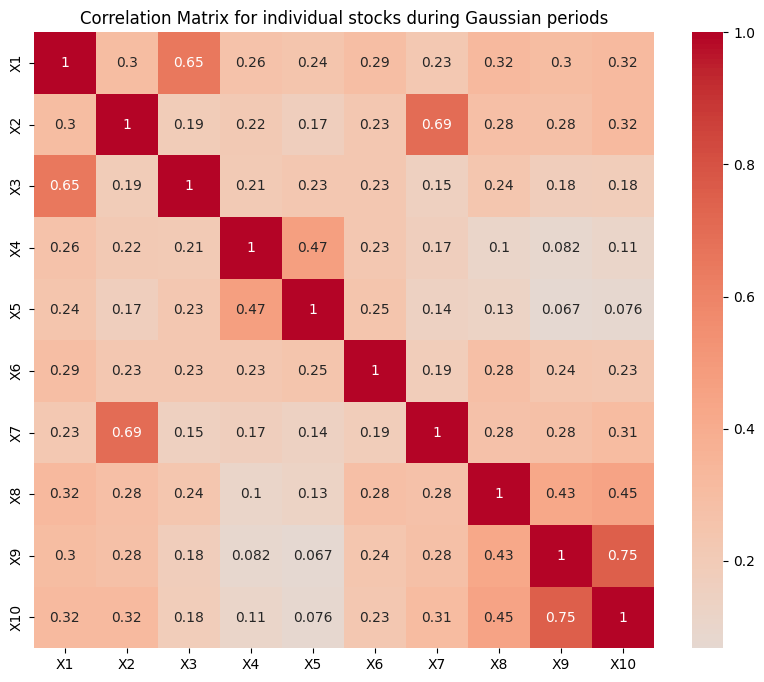

In [17]:
# Subset during Gaussian periods
gaussian_data = full.loc[gaussian_indices, 'X1':'X10']

# Compute the correlation matrix
corr_matrix = gaussian_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for individual stocks during Gaussian periods')
plt.savefig('../figures/corr_gaussian.png')
plt.show()

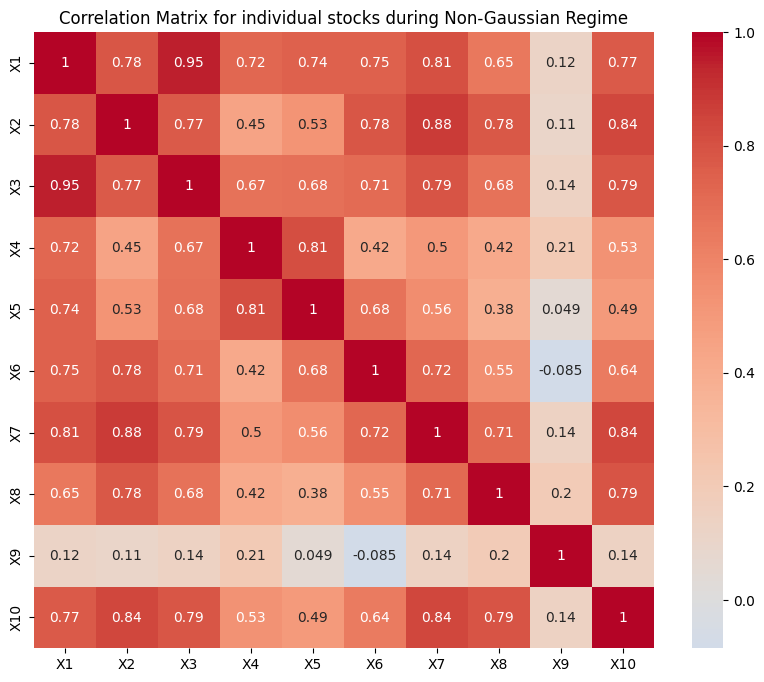

In [18]:
# Subset during non-Gaussian periods
non_gaussian_data = full.loc[non_gaussian_indices, 'X1':'X10']

# Compute the correlation matrix
corr_matrix = non_gaussian_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for individual stocks during Non-Gaussian Regime')
plt.savefig('../figures/corr_non_gaussian.png')
plt.show()

### Perform PCA

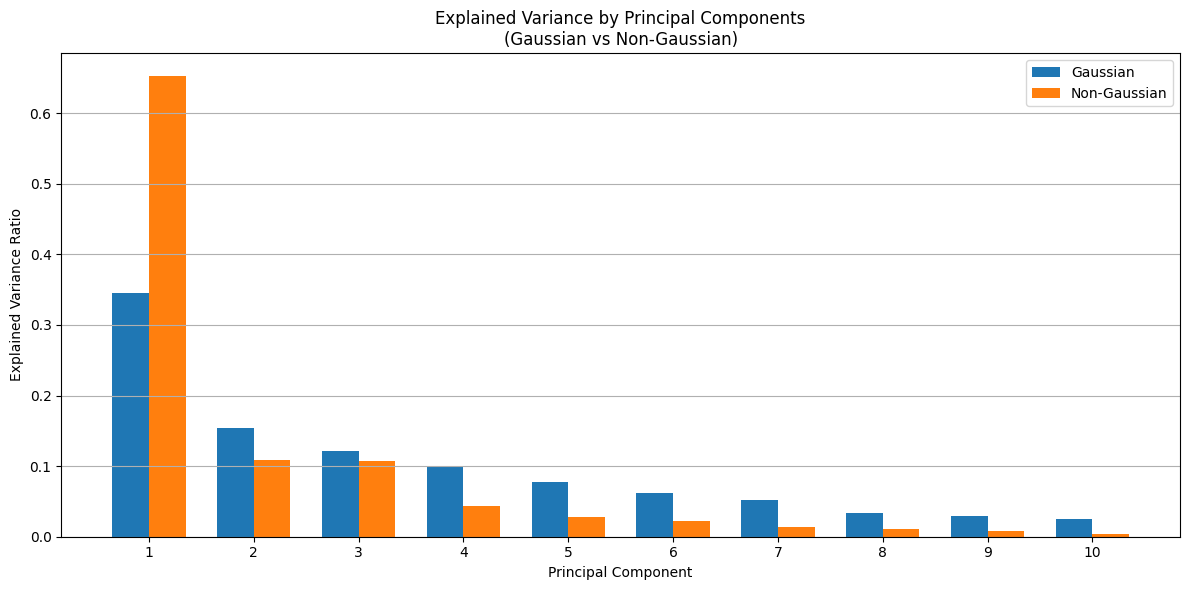

In [19]:
# 1. Standardize the data
scaler = StandardScaler()
gaussian_data_standardized = scaler.fit_transform(gaussian_data)
non_gaussian_data_standardized = scaler.fit_transform(non_gaussian_data)

# 2. Perform PCA
pca_gaussian = PCA()
pca_gaussian.fit(gaussian_data_standardized)

pca_non_gaussian = PCA()
pca_non_gaussian.fit(non_gaussian_data_standardized)

# 3. Explained variance ratios
explained_variance_gaussian = pca_gaussian.explained_variance_ratio_
explained_variance_non_gaussian = pca_non_gaussian.explained_variance_ratio_

# 4. Grouped bar chart version with full x-ticks
x = np.arange(1, len(explained_variance_gaussian) + 1)
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, explained_variance_gaussian, width=width, label='Gaussian')
plt.bar(x + width/2, explained_variance_non_gaussian, width=width, label='Non-Gaussian')

plt.title('Explained Variance by Principal Components\n(Gaussian vs Non-Gaussian)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(ticks=x)  # X축 tick 1, 2, 3, ..., 10 전부 표시
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../figures/PCA_variance_Gaussian_vs_NonGaussian.png')
plt.show()

In [20]:
# 1. Create DataFrames for both loading matrices

# Non-Gaussian
loading_matrix_non_gaussian = pca_non_gaussian.components_.T
loading_matrix_df_non = pd.DataFrame(
    loading_matrix_non_gaussian,
    columns=[f'PC{i+1}' for i in range(loading_matrix_non_gaussian.shape[1])],
    index=gaussian_data.columns 
)

# Gaussian
loading_matrix_gaussian = pca_gaussian.components_.T
loading_matrix_df_gaussian = pd.DataFrame(
    loading_matrix_gaussian,
    columns=[f'PC{i+1}' for i in range(loading_matrix_gaussian.shape[1])],
    index=gaussian_data.columns
)

# 2. Display the loading matrices with titles

# Display Gaussian loading matrix
print('\n=== PCA Loading Matrix: Gaussian Periods ===\n')
display(loading_matrix_df_gaussian.style.format("{:.4f}").set_caption("PCA Loading Matrix - Gaussian Periods"))

# Display Non-Gaussian loading matrix
print('\n=== PCA Loading Matrix: Non-Gaussian Periods ===\n')
display(loading_matrix_df_non.style.format("{:.4f}").set_caption("PCA Loading Matrix - Non-Gaussian Periods"))


=== PCA Loading Matrix: Gaussian Periods ===



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
X1,-0.3658,-0.2166,0.3230,-0.3835,0.0798,-0.0843,0.0461,0.6577,0.3453,-0.0227
X2,-0.3480,0.0763,-0.5381,-0.2548,-0.0295,-0.0494,0.0079,0.2863,-0.6558,-0.0570
X3,-0.2967,-0.2998,0.3707,-0.4906,0.0796,-0.0318,-0.0610,-0.6044,-0.2590,0.0246
X4,-0.2285,-0.4681,-0.1603,0.3697,0.2864,-0.0776,0.6848,-0.0905,0.0188,-0.0281
X5,-0.2183,-0.4932,-0.1069,0.3895,0.1717,0.2082,-0.6853,0.0568,-0.0129,0.0103
X6,-0.2803,-0.1467,0.0717,0.2431,-0.8518,-0.3268,0.0055,-0.0456,0.0190,0.0286
X7,-0.3238,0.1285,-0.5771,-0.2468,-0.0048,0.0029,-0.0772,-0.3143,0.6159,0.0255
X8,-0.3355,0.2066,0.1561,0.0988,-0.2106,0.8526,0.1955,-0.0081,-0.0178,-0.0278
X9,-0.3552,0.3999,0.2018,0.2607,0.2167,-0.2513,-0.0976,-0.0875,-0.0020,-0.6913
X10,-0.3675,0.3929,0.1682,0.2475,0.2409,-0.2078,-0.0432,-0.0117,-0.0566,0.7174



=== PCA Loading Matrix: Non-Gaussian Periods ===



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
X1,-0.3681,0.0145,-0.1336,0.0158,-0.4030,-0.3156,-0.1060,-0.0669,0.0341,-0.7532
X2,-0.3515,0.0777,0.2950,-0.1694,0.1004,0.1940,-0.2182,-0.6377,-0.5004,0.0472
X3,-0.3625,-0.0096,-0.0678,0.0932,-0.4972,-0.4368,0.0297,0.0856,-0.1508,0.6214
X4,-0.2789,-0.2046,-0.5598,0.3824,0.1429,0.2107,-0.0063,-0.4357,0.3854,0.1320
X5,-0.2964,0.0646,-0.5578,-0.1756,0.3444,0.0993,-0.0641,0.4439,-0.4848,-0.0368
X6,-0.3188,0.3259,0.0088,-0.6140,0.2413,-0.1873,0.3239,-0.0937,0.4491,0.0800
X7,-0.3524,0.0206,0.2171,-0.1063,-0.2295,0.5342,-0.4802,0.3572,0.3377,0.0820
X8,-0.3082,-0.1201,0.3822,0.3864,0.5714,-0.4176,-0.2217,0.1807,0.1095,-0.0220
X9,-0.0609,-0.9087,0.0593,-0.3973,0.0075,-0.0353,0.0869,0.0186,-0.0038,-0.0099
X10,-0.3454,-0.0294,0.2630,0.2999,-0.0615,0.3488,0.7375,0.1590,-0.1199,-0.1087


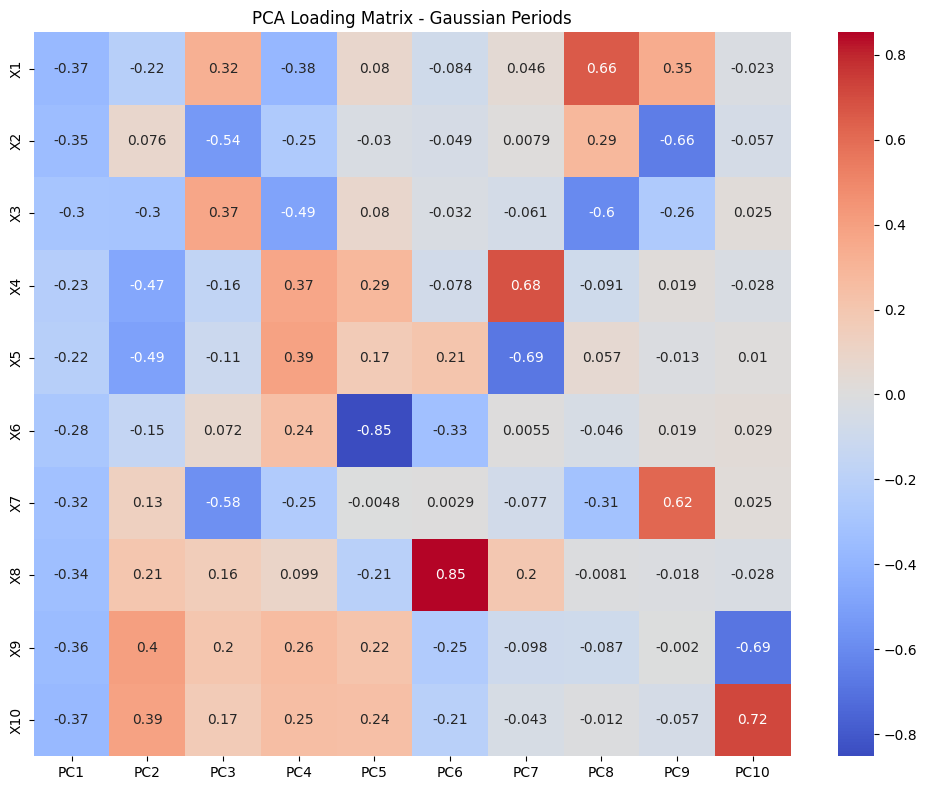

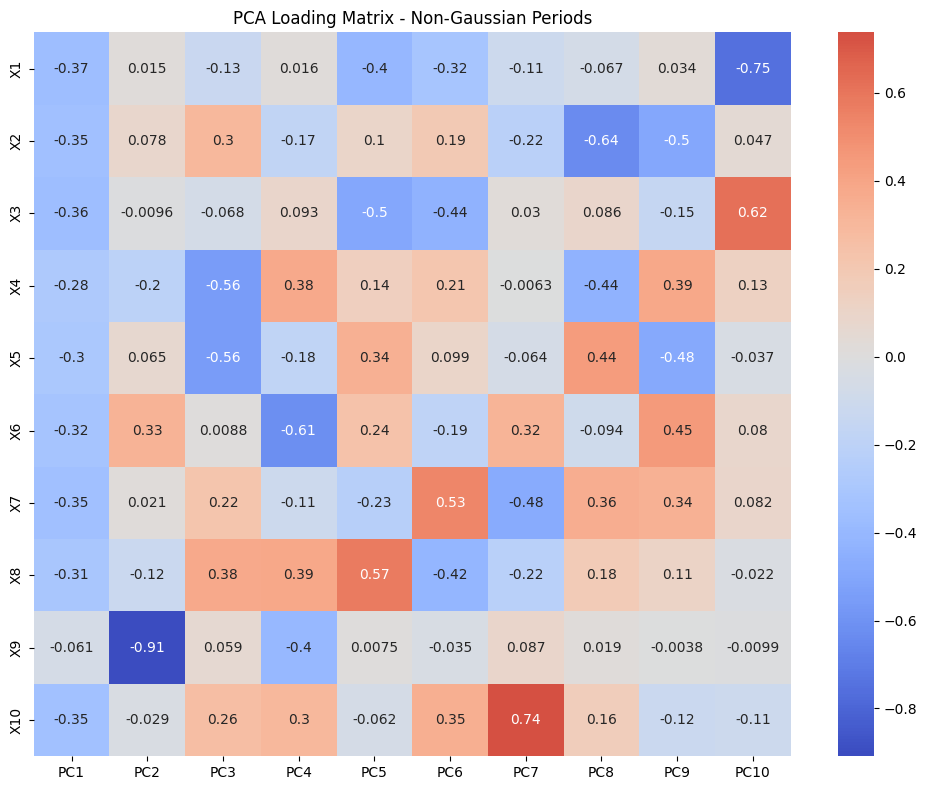

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(loading_matrix_df_gaussian, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loading Matrix - Gaussian Periods')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(loading_matrix_df_non, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loading Matrix - Non-Gaussian Periods')
plt.tight_layout()
plt.show()

In [22]:
# 1. Subset X variables from full
X_all = full.loc[:, 'X1':'X10']

# 2. Standardize X_all
scaler = StandardScaler()
X_all_std = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns, index=X_all.index)

# 3. Perform PCA on all periods
pca_all = PCA()
pca_all.fit(X_all_std)

# 4. Extract loading matrix
loading_matrix_all = pca_all.components_.T
loading_matrix_df_all = pd.DataFrame(
    loading_matrix_all,
    columns=[f'PC{i+1}' for i in range(loading_matrix_all.shape[1])],
    index=X_all.columns
)

# 5. Display loading matrix
print('\n=== PCA Loading Matrix: All Periods ===\n')
display(loading_matrix_df_all.style.format("{:.4f}").set_caption("PCA Loading Matrix - All Periods"))


=== PCA Loading Matrix: All Periods ===



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
X1,0.3893,0.1864,-0.4043,-0.0931,-0.2828,-0.0044,0.0887,-0.0122,0.6721,0.3192
X2,0.3717,-0.3305,0.3621,-0.0618,-0.3033,0.0912,-0.0545,0.0587,0.2794,-0.6580
X3,0.3360,0.2631,-0.4634,-0.0963,-0.4043,0.0174,-0.1012,0.0038,-0.5996,-0.2455
X4,0.2730,0.4546,0.3512,0.2190,0.0558,-0.2487,0.4504,0.5230,-0.0777,0.0147
X5,0.2623,0.5014,0.3394,0.1240,0.1583,-0.1489,-0.4481,-0.5464,0.0509,-0.0121
X6,0.3145,0.1137,0.0075,-0.1972,0.4591,0.7889,0.1043,0.0421,-0.0568,0.0118
X7,0.3539,-0.3767,0.3784,-0.0351,-0.3007,0.0595,-0.1034,-0.0082,-0.2906,0.6319
X8,0.3263,-0.2430,-0.2307,-0.0210,0.4812,-0.3337,-0.5031,0.4297,0.0119,-0.0016
X9,0.0733,-0.1332,-0.1749,0.9344,-0.0395,0.2587,-0.0648,-0.0106,0.0169,-0.0100
X10,0.3436,-0.3117,-0.1588,0.0350,0.3196,-0.3211,0.5445,-0.4876,-0.1180,-0.0705


### PCR Result

## 3) Model Performance

### Comparison of model performance between PCR and Polynomial Regression

Polynomial Regression + Ridge Train RMSE: 0.4209713520763193
Polynomial Regression + Ridge Test RMSE: 0.44633214229880736
Principal Component Regression Train RMSE: 0.47306822095852524
Principal Component Regression Test RMSE: 0.3864686769990845


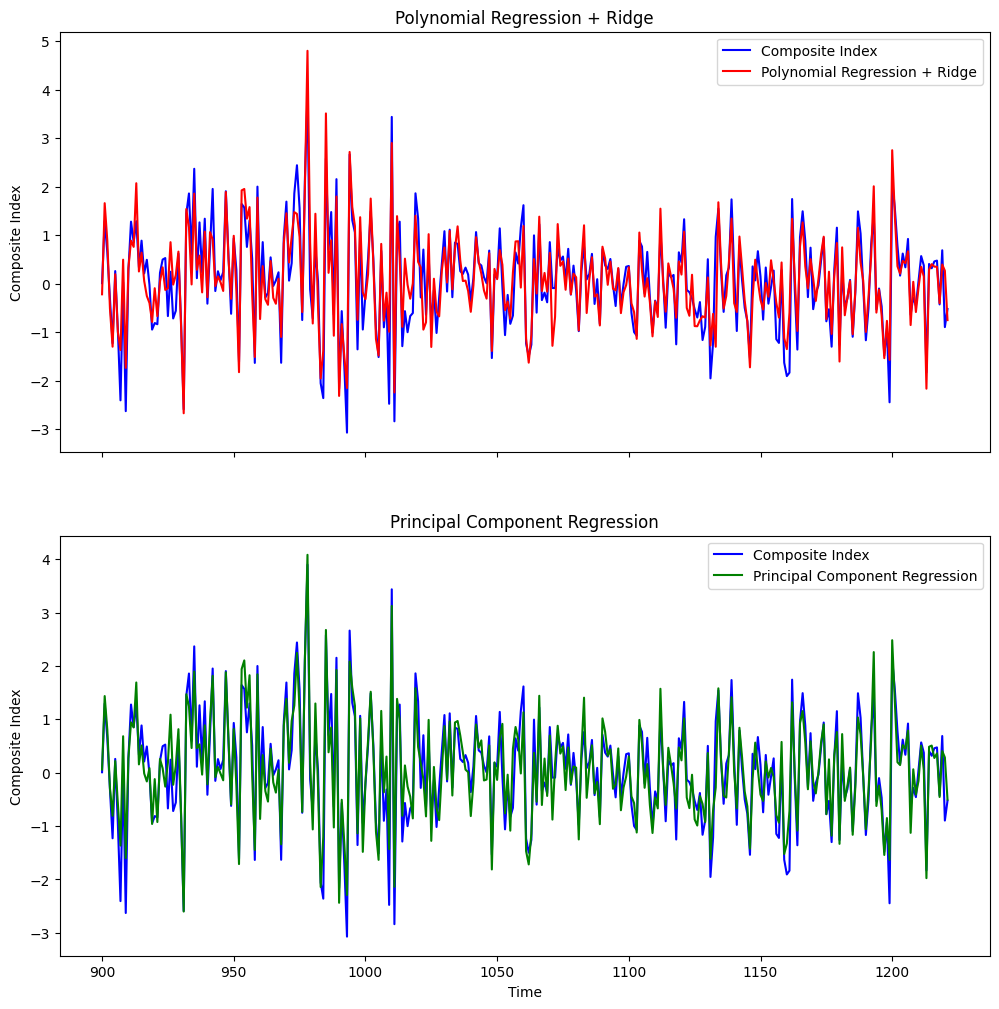

In [23]:
# 설명변수와 타겟변수 지정
X = full[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']]
y = full['Y']

# Regularization
alpha = 10

# Train/Test 분리
X_train, X_test = X.iloc[0:900], X.iloc[900:]
y_train, y_test = y.iloc[0:900], y.iloc[900:]

# Polynomial Regression + Ridge
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

ridge = Ridge(alpha=alpha)
ridge.fit(X_train_poly, y_train)
y_train_pred_ridge = ridge.predict(X_train_poly)
y_test_pred_ridge = ridge.predict(X_test_poly)

train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

print(f'Polynomial Regression + Ridge Train RMSE: {train_rmse_ridge}')
print(f'Polynomial Regression + Ridge Test RMSE: {test_rmse_ridge}')

# Principal Component Regression (PCR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lr = Ridge(alpha=alpha)
lr.fit(X_train_pca, y_train)
y_train_pred_pcr = lr.predict(X_train_pca)
y_test_pred_pcr = lr.predict(X_test_pca)

train_rmse_pcr = np.sqrt(mean_squared_error(y_train, y_train_pred_pcr))
test_rmse_pcr = np.sqrt(mean_squared_error(y_test, y_test_pred_pcr))

print(f'Principal Component Regression Train RMSE: {train_rmse_pcr}')
print(f'Principal Component Regression Test RMSE: {test_rmse_pcr}')

# 결과 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

x_indices = range(900, 900 + len(y_test))

# Polynomial Regression + Ridge 예측
axes[0].plot(x_indices, y_test.values, label='Composite Index', color='blue')
axes[0].plot(x_indices, y_test_pred_ridge, label='Polynomial Regression + Ridge', color='red')
axes[0].set_title('Polynomial Regression + Ridge')
axes[0].set_ylabel('Composite Index')
axes[0].legend()

# Principal Component Regression 예측
axes[1].plot(x_indices, y_test.values, label='Composite Index', color='blue')
axes[1].plot(x_indices, y_test_pred_pcr, label='Principal Component Regression', color='green')
axes[1].set_title('Principal Component Regression')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Composite Index')
axes[1].legend()

# plt.suptitle('Multi-task learning models')
plt.savefig('../figures/multi_task.png')
plt.show()


## Bonus) PCA portfolio

Y looks like it's in %, converting to decimal
X looks like it's in %, converting to decimal


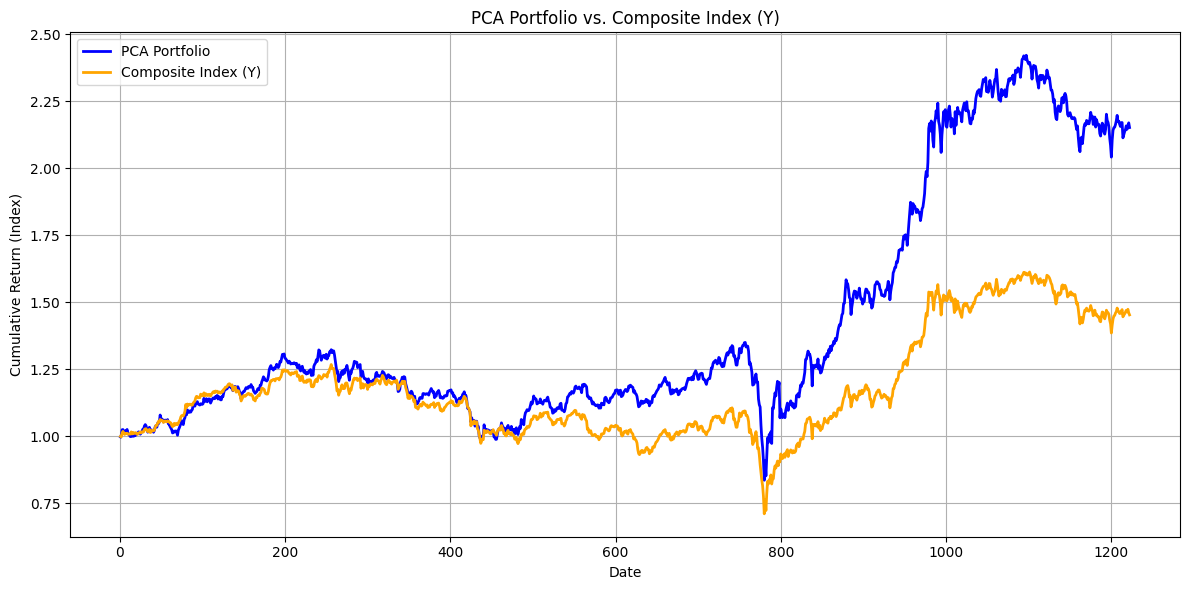

In [24]:
# 1. Prepare data
X = full[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']]
Y = full['Y']

# 2. 자동 체크: 수익률이 %인지 확인하고 변환
if Y.abs().max() > 0.5:  # 일일 수익률은 보통 0.5보다 작음
    print("Y looks like it's in %, converting to decimal")
    Y = Y / 100

if X.abs().max().max() > 0.5:
    print("X looks like it's in %, converting to decimal")
    X = X / 100

# 3. Standardize X
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# 4. Perform PCA (PC1만 사용)
pca = PCA(n_components=1)
pca.fit(X_std)
pc1 = pd.Series(index=X.columns, data=pca.components_[0])

# 5. PCA portfolio weights
weights = abs(pc1) / sum(abs(pc1))

# 6. PCA portfolio returns 계산
pca_portfolio_returns = (weights * X).sum(axis=1)

# 7. 누적 수익률 → 지수화 (index 값처럼 보기 위해 exp 적용)
pca_portfolio_index = pca_portfolio_returns.cumsum().apply(np.exp)
composite_index = Y.cumsum().apply(np.exp)

# 8. 비교 DataFrame 구성
df_compare = pd.DataFrame({
    'PCA Portfolio': pca_portfolio_index,
    'Composite Index (Y)': composite_index
}, index=Y.index)

# 9. Plot - 겹쳐서 그리기
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['PCA Portfolio'], label='PCA Portfolio', color='blue', linewidth=2)
plt.plot(df_compare.index, df_compare['Composite Index (Y)'], label='Composite Index (Y)', color='orange', linewidth=2)

plt.title('PCA Portfolio vs. Composite Index (Y)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Index)')
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.savefig('../figures/PCA_vs_CompositeIndex_overlay.png')
plt.show()